## iTEBD 
### I am going to use Inverse cononical form $X_l =\Lambda_{l}^{-1} $
### $\Psi_l = \Lambda_{l-1}~\Gamma_{l} ~\Lambda_{l} $
### Wavefunction = $\Psi_l ~X_l ~ \Psi_{l+1} ~ X_{l+1} \Psi_{l+1}$  = $\Psi_A ~X_A ~ \Psi_{B} ~ X_{B} \Psi_{A}$ 

### Appl gate and SVD on $AB$ first then $BA$
### There four tensors to take into account $\Psi_A ,X_A , \Psi_{B} ,X_{B}$
### SVD on $\Psi_A ~X_A ~ \Psi_{B}$ take $USV = US ~S^{-1} ~SV = \Psi_A X_A \Psi_B$
### Started state is Neel state


In [8]:
using TensorOperations
using PyPlot
function dosvdtrunc(A,trunc,m0,max)		# AA a matrix;  keep at most m states
    (u,d,v) = svd(A)
    prob = dot(d,d)		# total probability
    e = 1
    m = m0-1
    while e > trunc && m<max
        m +=1
        dm = d[1:m]
        e = (prob - dot(dm,dm) )/prob
    end
#     mm = min(m,length(d))	# number of states to keep
#     d = d[1:mm]			# middle matrix in vector form
#     trunc = (prob - dot(d,d))   
#     @show e
    U = u[:,1:m]
    V = v[:,1:m]'
    d = d[1:m]
    (U, d, V, m, e)		# AA == U * diagm(d) * V	with error trunc,  mm is number of length(d) after truncation
end
;

In [20]:
tau = 0.01
trunc = 1e-7
d = 2
num_step = 900
m_max = 1000


sz = Float64[0.5 0; 0 -0.5] ; sp = Float64[0 1; 0 0] ; sm = sp'
H =  0.5 * (kron(sp,sm) + kron(sm,sp)) + kron(sz,sz)
taugate = reshape(expm(- 1im *tau * H),2,2,2,2); # [s1, s2, sp1, sp2]
psi_A , psi_B , X_A, X_B =zeros(1,2,1), zeros(1,2,1), ones(1,1), ones(1,1); ##initializing  
psi_A[1,1,1] = 1 #psi_A is up  1 is up 2 is down
psi_B[1,2,1] = 1 #psi_B is down
szA_list = []
szB_list = []
EntropyA_list =[]
EntropyB_list =[]
N=1
m0 = 1
for step=1:num_step
    ################################################################# AB
    a1 ,d, a2 = size(psi_A)
    b1, d, b2 = size(psi_B)
    @tensor begin
        M_AB[i, s1p, s2p, l] := psi_A[i, s1, j] * X_A[j, k] * psi_B[k, s2, l] * taugate[s1, s2, s1p, s2p]
    end
    
    (U, s, V, m, e) = dosvdtrunc(reshape(M_AB, a1*d, b2*d),trunc, m0, m_max)
    m0=m
    
    N = dot(s,s) ## Normsquare 
    
    num_step%50 ==0 && (s/= sqrt(N)) # Normalizing every 50 sweeps
    
    psi_A = reshape(U * diagm(s), a1, d, m)
    psi_B = reshape(diagm(s) * V, m, d, b2)
    X_A = diagm(1./s) ## d^(-1) == inv(diagm(d))
    
    ############ measuring sz on A


    
    @tensor begin
        sz_A = real(scalar(psi_A[i, s1, j] * X_A[j,k] * psi_B[k, s2, l] * sz[s1,s1p]* 
                                                        conj(psi_A[i,s1p,jp] * X_A[jp,kp] *psi_B[kp,s2,l]) ))
        
#         N = scalar(psi_A[i, s1, j] * X_A[j,k] * psi_B[k, s2, l] * conj(psi_A[i,s1,jp]* X_A[jp,kp] *psi_B[kp,s2,l])) 
    end

    EntropyA = - sum(2*s.^2.*log(s))

    push!(szA_list,sz_A/N)
    push!(EntropyA_list, EntropyA)
    ################################################################# to BA
    a1 ,d, a2 = size(psi_A)
    b1, d, b2 = size(psi_B)
    @tensor begin
        M_BA[i, s1p, s2p, l] := psi_B[i, s1, j] * X_B[j, k] * psi_A[k, s2, l] * taugate[s1, s2, s1p, s2p]
    end
    (U, s, V, m, e) = dosvdtrunc(reshape(M_BA, b1*d, a2*d),trunc, m0, m_max)
    m0=m
    
    N = dot(s,s)
    num_step%50 ==0 && (s/= sqrt(N)) ## Normalizing every 50 sweeps
    
    psi_B = reshape(U * diagm(s), b1, d, m)
    psi_A = reshape(diagm(s) * V, m, d, a2)
    X_B = diagm(1./s)
    
    ################ Finding sz on B
    
    
    @tensor begin
        sz_B = real(scalar(psi_B[i, s1, j] * X_B[j,k] * psi_A[k, s2, l] * sz[s1,s1p]* 
                                                        conj(psi_B[i,s1p,jp] * X_B[jp,kp] *psi_A[kp,s2,l]) ) )       
    end
    EntropyB = - sum(2*s.^2.*log(s))
    
    push!(szB_list,sz_B/N)
    push!(EntropyB_list, EntropyB)

    step%100 ==0 && (@show sqrt(N), step, m) #### print info every 100 sweeps

end

(sqrt(N),step,m) = (0.9999999907852172,100,4)
(sqrt(N),step,m) = (0.9999999519700942,200,7)
(sqrt(N),step,m) = (0.9999999553209518,300,12)
(sqrt(N),step,m) = (0.999999958877763,400,22)
(sqrt(N),step,m) = (0.9999999521810944,500,35)
(sqrt(N),step,m) = (0.9999999529261856,600,59)
(sqrt(N),step,m) = (0.9999999538416342,700,97)
(sqrt(N),step,m) = (0.9999999509886387,800,159)
(sqrt(N),step,m) = (0.9999999501595181,900,258)


N = 0.9999999003190387
size(psi_A) = (258,2,258)


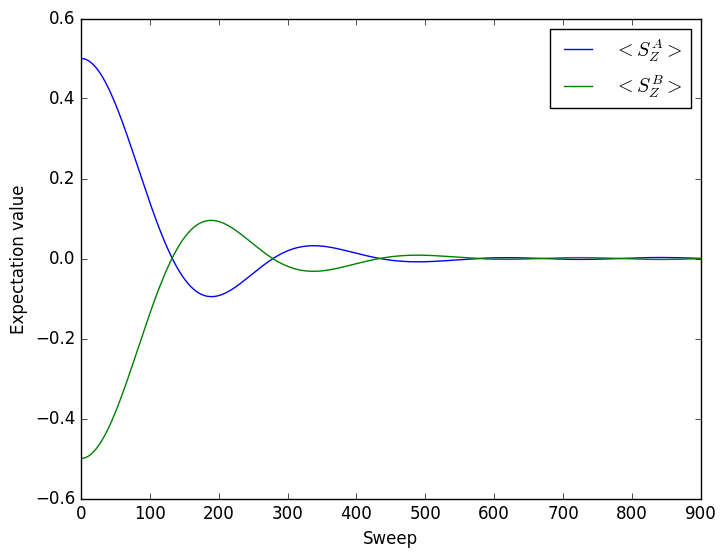

In [21]:
@show N
@show size(psi_A)
plot(1:num_step,szA_list, label=L"$<S_Z^A>$");
plot(1:num_step,szB_list,label =L"$<S_Z^B>$" );
legend();
xlabel("Sweep");
ylabel("Expectation value");

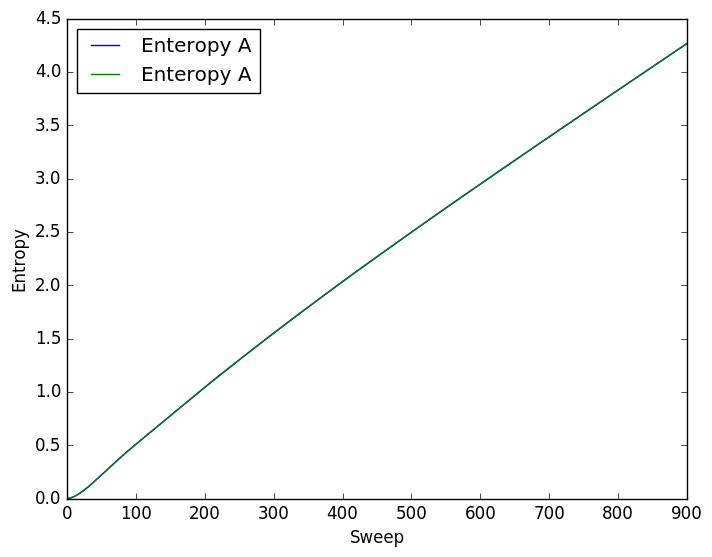

In [22]:
plot(1:num_step, EntropyA_list,label="Enteropy A")
plot(1:num_step, EntropyB_list,label="Enteropy A")
legend(loc="best");
xlabel("Sweep");
ylabel("Entropy");

# Adiabatic theorem of quantum mechanics
## $H_t = S_i^zS_{i+1}^z + \frac{1}{2}(t/T)(S^+_iS^-_{i+1}S^-_iS^+_{i+1}) $
## $U = \prod_j^N Exp(- i \tau H(j\tau) $ and $\tau = T/N$  (N is number of step)
## $H(j ~\tau) = H_0 + \frac{j~\tau}{T}H_1= H_0 + \frac{j}{N}H_1$ 


In [30]:
tau = 0.1
trunc = 1e-8
d = 2
num_step = 6000   #### Here T = num_step * tau
m_max = 200

sz = Float64[0.5 0; 0 -0.5] ; sp = Float64[0 1; 0 0] ; sm = sp'
H_T = reshape( 0.5 * (kron(sp,sm) + kron(sm,sp)) + kron(sz,sz),2,2,2,2); # [s1, s2, s1p, s2p]



psi_A , psi_B , X_A, X_B =zeros(1,2,1), zeros(1,2,1), ones(1,1), ones(1,1); ##initializing  
psi_A[1,1,1] = 1 #psi_A is up  1 is up 2 is down
psi_B[1,2,1] = 1 #psi_B is down
szA_list = []
szB_list = []
EnergyA_list =[]
EnergyB_list =[]
N=1
m0 = 1
for step=1:num_step
    ##### H varies with time
    
    H = (step/num_step)* 0.5 * (kron(sp,sm) + kron(sm,sp)) + kron(sz,sz)
    taugate = reshape(expm(- 1im *tau * H),2,2,2,2); # [s1, s2, sp1, sp2]
    
    
    ################################################################# AB
    a1 ,d, a2 = size(psi_A)
    b1, d, b2 = size(psi_B)
    @tensor begin
        M_AB[i, s1p, s2p, l] := psi_A[i, s1, j] * X_A[j, k] * psi_B[k, s2, l] * taugate[s1, s2, s1p, s2p]
    end
    
    (U, s, V, m, e) = dosvdtrunc(reshape(M_AB, a1*d, b2*d),trunc, m0, m_max)
    m0=m
    
    N = dot(s,s)  ## Normsquare 
    num_step%50 ==0 && (s/= sqrt(N)) ## Normalizing every 50 sweeps
    
    psi_A = reshape(U * diagm(s), a1, d, m)
    psi_B = reshape(diagm(s) * V, m, d, b2)
    X_A = diagm(1./s) ## d^(-1) == inv(diagm(d))
    

    #####  ######### measuring sz on A

    
    @tensor begin
        sz_A = real(scalar(psi_A[i, s1, j] * X_A[j,k] * psi_B[k, s2, l] * sz[s1,s1p]*
                                                        conj(psi_A[i,s1p,jp] * X_A[jp,kp] *psi_B[kp,s2,l]) ))
       
        EnergyA = real(scalar(psi_A[i, s1, j] * X_A[j,k] * psi_B[k, s2, l] * H_T[s1, s2, s1p, s2p]*
                                                        conj(psi_A[i,s1p,jp] * X_A[jp,kp] *psi_B[kp,s2p,l]) ))
        
        

    end

    push!(szA_list,sz_A/N)
    push!(EnergyA_list, EnergyA/N)
    
    ################################################################# to BA
    
    
    a1 ,d, a2 = size(psi_A)
    b1, d, b2 = size(psi_B)
    @tensor begin
        M_BA[i, s1p, s2p, l] := psi_B[i, s1, j] * X_B[j, k] * psi_A[k, s2, l] * taugate[s1, s2, s1p, s2p]
    end
    (U, s, V, m, e) = dosvdtrunc(reshape(M_BA, b1*d, a2*d),trunc, m0, m_max)
    m0=m
    
    N = dot(s,s)  ## Normsquare 
    num_step%50 ==0 && (s/= sqrt(N)) ## Normalizing every 50 sweeps
    
    psi_B = reshape(U * diagm(s), b1, d, m)
    psi_A = reshape(diagm(s) * V, m, d, a2)
    X_B = diagm(1./s)
    
    #################### Finding sz on B

    
    @tensor begin
        sz_B = real(scalar(psi_B[i, s1, j] * X_B[j,k] * psi_A[k, s2, l] * sz[s1,s1p]* 
                                                        conj(psi_B[i,s1p,jp] * X_B[jp,kp] *psi_A[kp,s2,l]) ) ) 
        
        EnergyB = real(scalar(psi_B[i, s1, j] * X_B[j,k] * psi_A[k, s2, l] * H_T[s1, s2, s1p, s2p]*
                                                        conj(psi_B[i,s1p,jp] * X_B[jp,kp] *psi_A[kp,s2p,l]) ))
    end
    push!(szB_list,sz_B/N)
    push!(EnergyB_list, EnergyB/N)

    step%500 ==0 && (@show sqrt(N), step, m, EnergyB/N)

end



(sqrt(N),step,m,EnergyB / N) = (0.9999999997290806,500,3,-0.28952743292268984)
(sqrt(N),step,m,EnergyB / N) = (0.9999999980361034,1000,4,-0.32538063674644807)
(sqrt(N),step,m,EnergyB / N) = (0.9999999985486514,1500,5,-0.35561658704187593)
(sqrt(N),step,m,EnergyB / N) = (0.9999999981257545,2000,10,-0.38188320871793324)
(sqrt(N),step,m,EnergyB / N) = (0.9999999982421283,2500,10,-0.4027445818925863)
(sqrt(N),step,m,EnergyB / N) = (0.999999997412925,3000,11,-0.417852679436394)
(sqrt(N),step,m,EnergyB / N) = (0.9999999957846557,3500,15,-0.4287944473560064)
(sqrt(N),step,m,EnergyB / N) = (0.9999999965024631,4000,20,-0.4357012325442109)
(sqrt(N),step,m,EnergyB / N) = (0.9999999955577124,4500,31,-0.43957457906860725)
(sqrt(N),step,m,EnergyB / N) = (0.9999999954669806,5000,48,-0.44138985819027066)
(sqrt(N),step,m,EnergyB / N) = (0.9999999957637968,5500,70,-0.44185609919509555)
(sqrt(N),step,m,EnergyB / N) = (0.999999995099369,6000,100,-0.4421030204784284)


N = 0.999999990198738
size(psi_A) = (100,2,100)


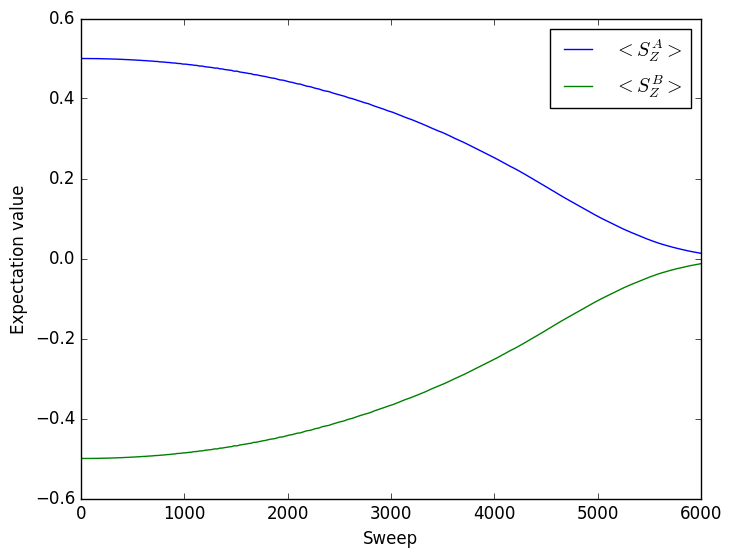

In [31]:
@show N
@show size(psi_A)
plot(1:num_step,szA_list, label=L"$<S_Z^A>$");
plot(1:num_step,szB_list,label =L"$<S_Z^B>$" );
legend();
xlabel("Sweep");
ylabel("Expectation value");

(EnergyA_list[end],EnergyB_list[end],0.25 - log(2)) = (-0.44312568871809005,-0.4421030204784284,-0.4431471805599453)


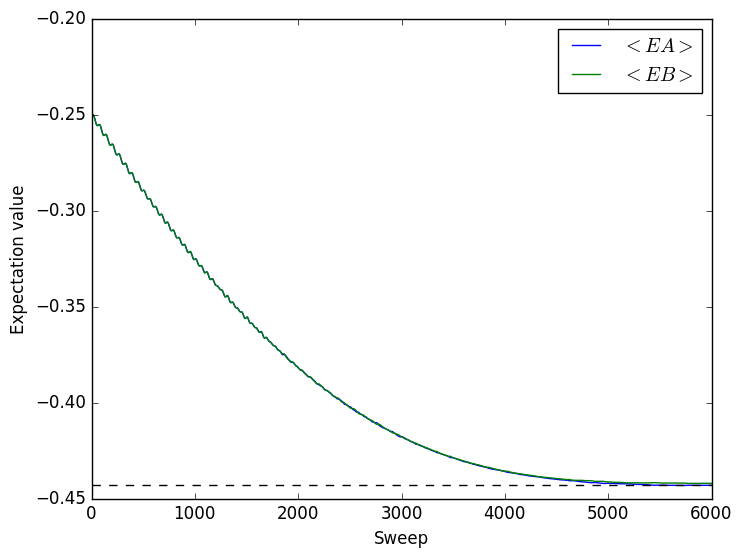

In [40]:
@show EnergyA_list[end] , EnergyB_list[end] ,0.25-log(2)
plot(1:num_step, EnergyA_list, label=L"$<EA>$");
plot(1:num_step, EnergyB_list, label =L"$<EB>$" );
axhline( .25-log(2), ls="--", c="k")
legend();
xlabel("Sweep");
ylabel("Expectation value");